<a href="https://colab.research.google.com/github/sujay-2001/cGAN-MNIST/blob/main/cGAN_MNIST_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional-GAN for CIFAR-10 (Tensorflow)

## Import required libraries

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt

In [ ]:
import random

## Check if tensorflow detects GPU

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Dataset

In [ ]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert the numpy arrays to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
BATCH_SIZE = 128
# Preprocess the dataset
dataset = dataset.map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y))
# Apply any additional transformations, such as batching, shuffling, etc.
dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size=BATCH_SIZE)

6


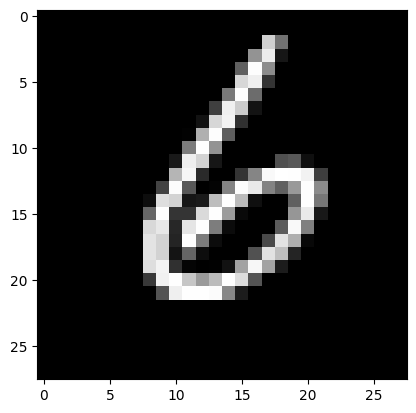

In [ ]:
for image,label in dataset:
    plt.imshow(image[0,:,:],cmap='gray')
    tf.print(label[0])
    break

## Discriminator Network

In [ ]:
def build_discriminator():
  #define input layers
  label = tfl.Input(shape=(1,))
  img = tfl.Input(shape=(28,28,1))
  # define neural network layers
  label_layer = tf.keras.Sequential([
      tfl.Embedding(10, 50),
      tfl.Dense(784),
      tfl.LeakyReLU(0.2),
      tfl.BatchNormalization(),
      tfl.Reshape((28,28,1))
      ])(label)

  concat = tfl.Concatenate(axis=-1)([img,label_layer])

  out_layer = tf.keras.Sequential([
      tfl.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
      tfl.LeakyReLU(0.2),
      tfl.BatchNormalization(),

      tfl.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
      tfl.LeakyReLU(0.2),
      tfl.BatchNormalization(),

      tfl.Reshape((6272,)),
      tfl.Flatten(),
      tfl.Dropout(0.4),
      tfl.Dense(1, activation='sigmoid')
      ])(concat)

  return tf.keras.Model([img,label],out_layer)

## Generator Network

In [ ]:
def build_generator():
  #define input layers
  label = tfl.Input(shape=(1,))
  seed = tfl.Input(shape=(100,))
  # define neural network layers
  seed_layer = tf.keras.Sequential([
      tfl.Dense(6272),
      tfl.ReLU(),
      tfl.BatchNormalization(),
      tfl.Reshape((7,7,128))
      ])(seed)

  label_layer = tf.keras.Sequential([
      tfl.Embedding(10, 50),
      tfl.Dense(49),
      tfl.BatchNormalization(),
      tfl.Reshape((7,7,1))
      ])(label)

  concat = tfl.Concatenate(axis=-1)([seed_layer,label_layer])

  out_layer = tf.keras.Sequential([
            tfl.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
            tfl.ReLU(),
            tfl.BatchNormalization(),

            tfl.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
            tfl.ReLU(),
            tfl.BatchNormalization(),

            tfl.Conv2D(1, (5,5), padding='same', activation='tanh')
        ])(concat)

  return tf.keras.Model([seed,label],out_layer)


## Check Generator Output

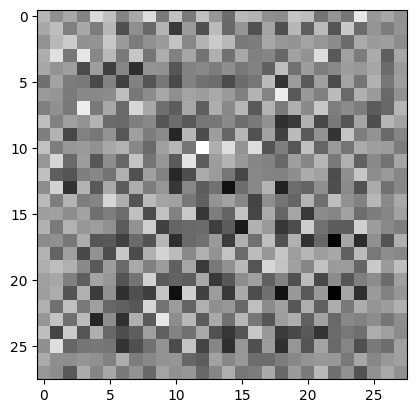

In [ ]:
generator = build_generator()

noise = tf.random.normal([1, 100])
label = tf.experimental.numpy.random.randint(0,9)
generated_image = generator([noise, tf.reshape(label,[1,1])], training=False)
generated_image = (generated_image+1.0)/2.0
plt.imshow(tf.reshape(generated_image,[28,28,1]),cmap='gray')

## Create Loss functions for Discriminator and Generator

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Create Optimizers for Discriminator and Generator

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

## Save Checkpoints

In [ ]:
import os

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define Training Loop

In [ ]:
EPOCHS = 50

In [ ]:
@tf.function
def train_step(images,labels):
    noise = tf.random.normal([images.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise,labels], training=True)

      real_output = discriminator([images,labels], training=True)
      fake_output = discriminator([generated_images,labels], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      disc_real_accuracy = tf.reduce_sum(real_output)/noise.shape[0]
      disc_fake_accuracy = 1-tf.reduce_sum(fake_output)/noise.shape[0]
      gen_accuracy = tf.reduce_sum(fake_output)/noise.shape[0]


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss,disc_real_accuracy,disc_fake_accuracy,gen_accuracy

## Generate and save images

In [ ]:
def generate_and_save_images(model, seed, epoch):
  # Notice `training` is set to False.
  labels = []
  for i in range(10):
    labels.append(tf.fill([1], i))
  predictions = model([seed,tf.reshape(labels,[10,1])], training=False)
  predictions = (predictions+1)/2
  f, axarr = plt.subplots(10, figsize=(1,15))
  for i in range(10):
    axarr[i].imshow(predictions[i,:,:,:], cmap = 'gray')
  plt.show()

## Training

In [ ]:
seed = tf.random.normal([10,100])
disc_loss = []
gen_loss = []
disc_real_accuracy = []
disc_fake_accuracy = []
gen_accuracy = []

In [ ]:
import time
from IPython import display

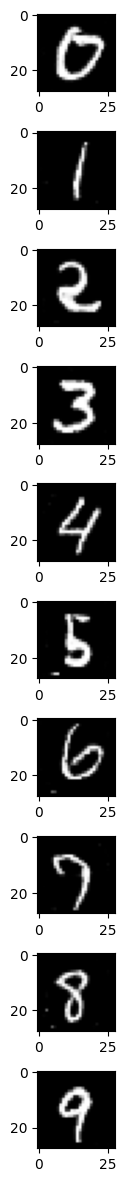

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    for images,labels in dataset:
      images = (images-0.5)*2.0
      g_loss,d_loss,d_real_accuracy,d_fake_accuracy,g_accuracy = train_step(images,labels)
      disc_loss.append(d_loss)
      gen_loss.append(g_loss)
      disc_real_accuracy.append(d_real_accuracy)
      disc_fake_accuracy.append(d_fake_accuracy)
      gen_accuracy.append(g_accuracy)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,seed,epoch + 1)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Discriminator Loss:{}, Generator Loss:{}\n'.format(disc_loss[-1],gen_loss[-1]))
    print ('D_real accuracy:{}, D_fake accuracy:{}, Generator accuracy:{}\n'.format(disc_real_accuracy[-1],disc_fake_accuracy[-1],gen_accuracy[-1]))
    print ('\nTime for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

# Generate after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator,seed,EPOCHS)

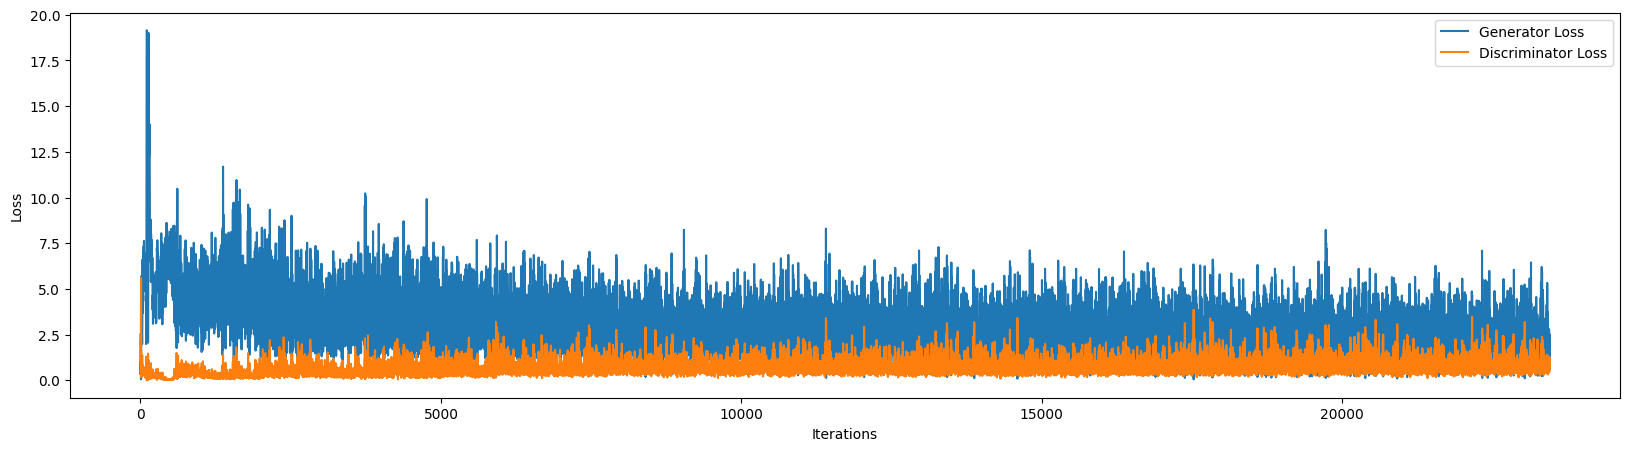

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(gen_loss, label='Generator Loss')
plt.plot(disc_loss, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

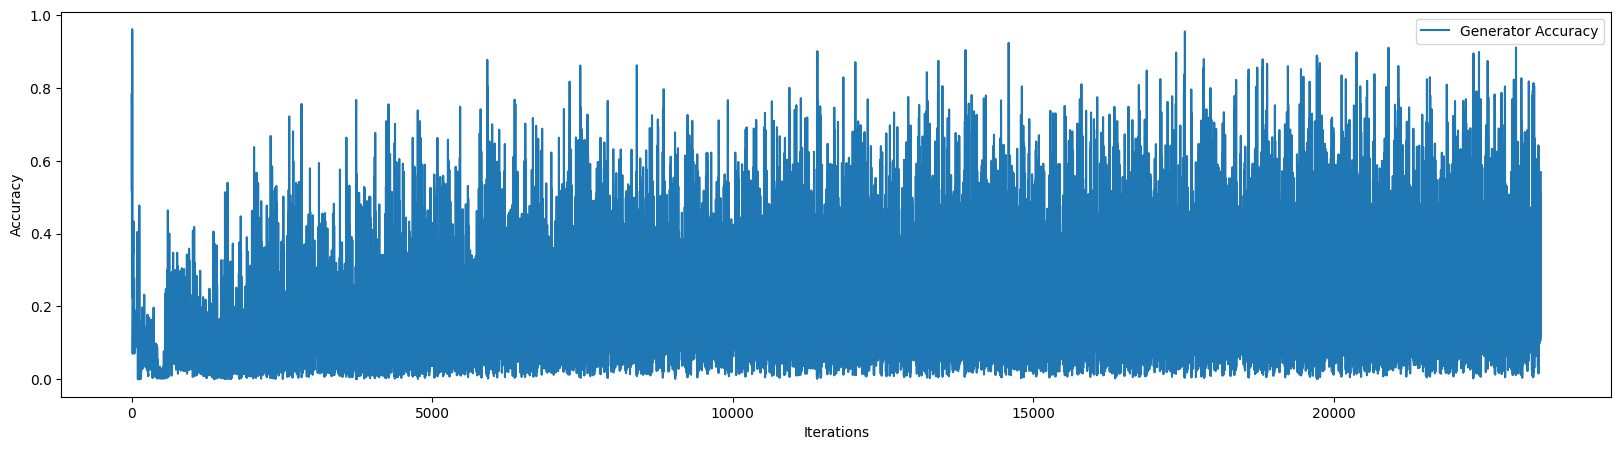

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(gen_accuracy, label='Generator Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

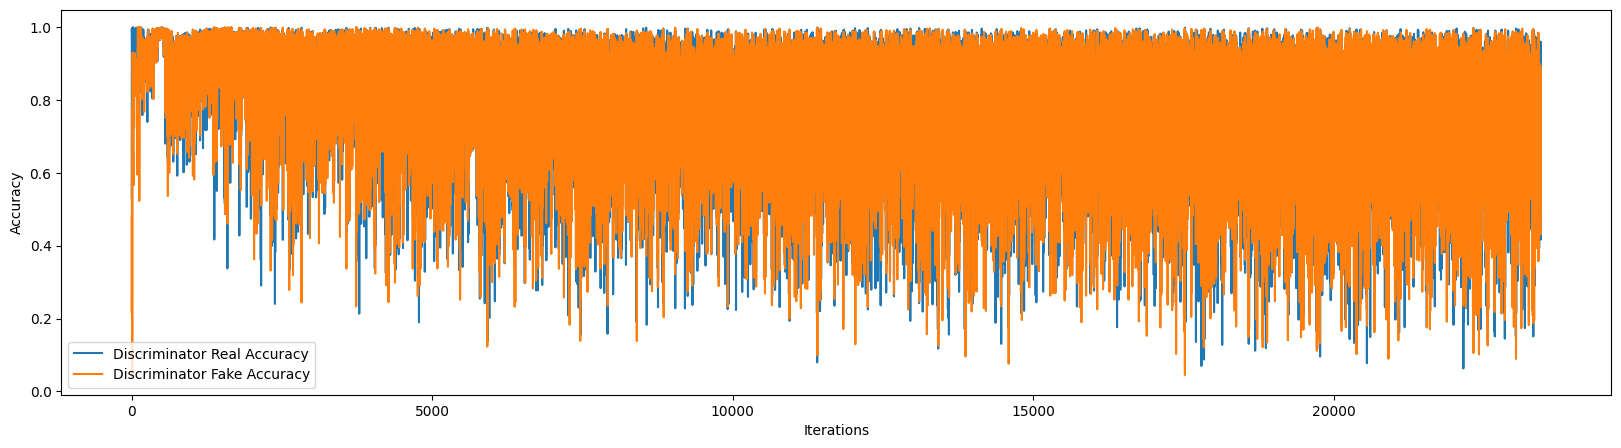

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(disc_real_accuracy, label='Discriminator Real Accuracy')
plt.plot(disc_fake_accuracy, label='Discriminator Fake Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Generate Images

### Class 9:

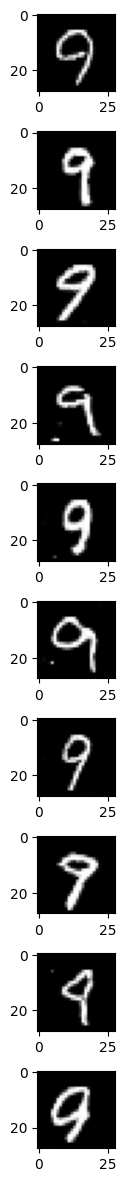

In [ ]:
label = tf.fill([10],9)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class: 8

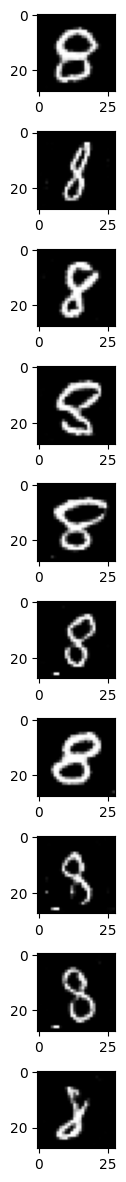

In [ ]:
label = tf.fill([10],8)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class: 7

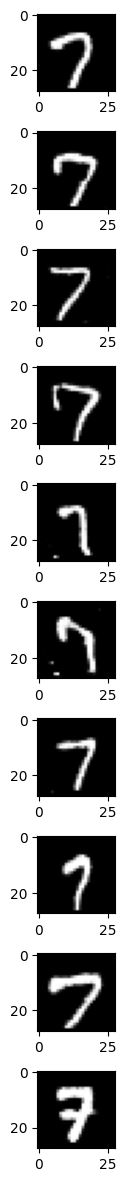

In [ ]:
label = tf.fill([10],7)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class:6

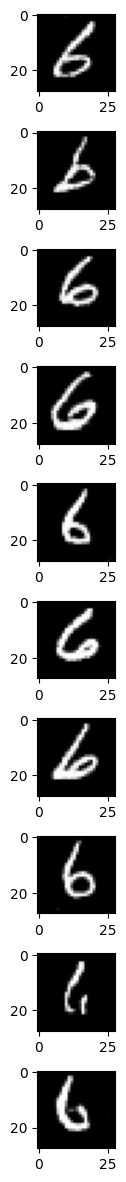

In [ ]:
label = tf.fill([10],6)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class:5

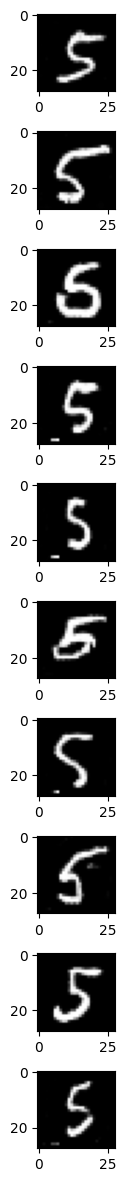

In [ ]:
label = tf.fill([10],5)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class:4

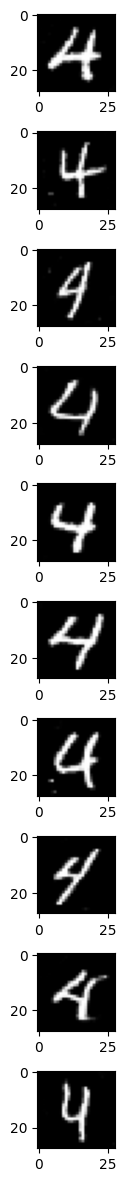

In [ ]:
label = tf.fill([10],4)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class:3

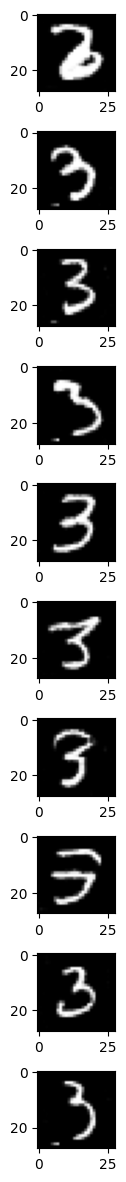

In [ ]:
label = tf.fill([10],3)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class:2

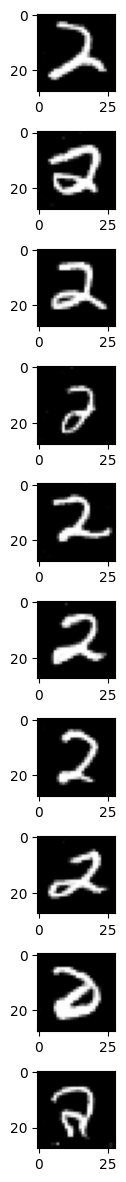

In [ ]:
label = tf.fill([10],2)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class:1

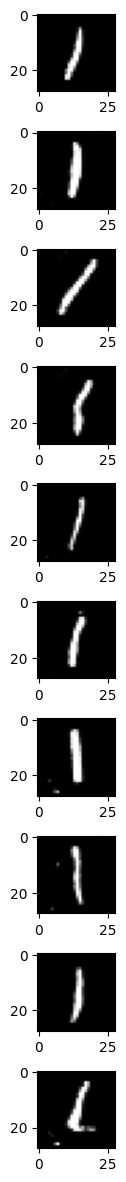

In [ ]:
label = tf.fill([10],1)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()

## Class:0

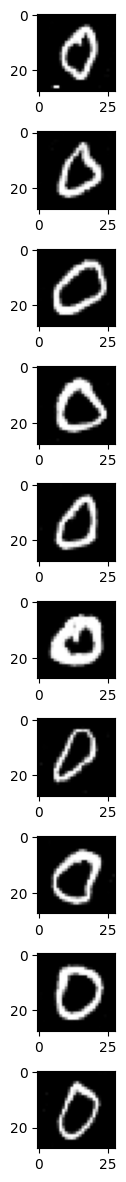

In [ ]:
label = tf.fill([10],0)
seed = tf.random.normal([10,100])
predictions = generator([seed,tf.reshape(label,[10,1])], training=False)
predictions = (predictions+1)/2
f, axarr = plt.subplots(10,figsize=(1,15))
for i in range(10):
  axarr[i].imshow(predictions[i,:,:,:], cmap='gray')
plt.show()